# Figure 1
- Most adhesome genes are active
- Active adhesome genes are close in Hi-C maps

### Setup

In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

/home/louiscam/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures0/correlation_clustering.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load adhesome components

In [4]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


In [5]:
# Intrinsic adhesome genes
intrinsic_adhesome_genes = np.unique(df_components[df_components['FA']=='Intrinsic Proteins']['Official Symbol'].values)
print('Number of intrinsic adhesome genes = '+str(len(intrinsic_adhesome_genes)))

Number of intrinsic adhesome genes = 150


### Determine active and inactive loci

In [6]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
H3K4me1,-1.008735,-2.015639,-0.505283,0.796121,0.699133,0.699133,0.765209,0.699133,0.645307,0.868093,...,-2.015639,-1.512187,-2.015639,-2.015639,0.322319,0.663696,0.920941,0.699133,0.780829,-2.015639
H3K4me2,-1.958933,-1.958933,-0.780395,0.903726,0.629325,0.777549,0.960422,1.110838,1.155592,0.587846,...,-1.958933,-1.369664,-1.958933,-1.958933,0.398144,0.706663,0.706663,0.842976,0.668873,-1.958933
H3K4me3,-0.762508,-1.559915,-0.296056,2.096163,2.047202,2.188246,1.942547,1.629711,2.096163,1.555465,...,-1.559915,-0.762508,-1.559915,-1.559915,1.089012,1.555465,2.096163,1.699454,2.047202,-1.559915
H3K36me3,-0.846516,-1.915456,0.502253,1.085439,0.909434,0.732414,1.053306,0.966577,0.947996,0.756895,...,-0.221226,0.119462,-0.312046,-0.221226,0.269171,0.756895,0.825993,0.780622,1.019776,-1.915456
H3K9ac,-2.030991,-3.572735,-1.408623,1.086720,1.328125,1.152158,1.381093,1.314479,1.152158,1.286674,...,-1.129128,-1.011953,-1.011953,-1.260118,0.635789,0.709143,1.183488,1.341605,0.943019,-3.572735
POLR2A,-0.789470,-0.789470,0.148832,3.123182,2.327504,2.456524,1.636007,1.389201,2.456524,1.636007,...,-0.789470,-0.789470,-0.789470,-0.789470,1.636007,1.636007,1.389201,2.184879,0.148832,-0.789470
H3K9me3,-4.012477,-6.973887,-3.677000,-0.596838,-0.485287,-1.461657,-1.556038,0.620154,-0.485287,-0.329699,...,-1.655523,-1.126180,-1.556038,-1.655523,-0.186247,0.030477,-0.186247,-1.051067,0.260780,-6.973887
H3K27me3,-0.207024,-1.800421,-1.297760,0.641495,0.407424,0.295636,-0.501062,0.407424,0.372042,0.562305,...,-1.800421,-1.800421,-1.800421,-1.297760,0.562305,0.210222,0.616047,0.254186,0.798297,-1.800421
RNAseq,-0.580582,-1.212921,0.481148,1.608928,1.932739,1.820298,1.605801,1.055406,0.703510,1.027435,...,-0.630660,-0.515558,-1.436824,-1.274597,0.548814,1.118235,1.479756,1.333030,0.878212,-1.991482
ATACseq,-0.649909,-1.994005,-1.994005,1.160163,1.077385,1.148882,1.051953,0.844721,0.984326,0.925460,...,-1.474038,-1.994005,-0.534272,1.038907,0.984326,1.113985,1.077385,-0.434103,-1.994005,-1.994005


In [7]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(df_all_norm.T)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of loci = 11537
Number of loci in cluster 0 = 5085
Number of loci in cluster 1 = 6452


In [8]:
# Load adhesome loci and add column to df_clusters
df_clusters = pickle.load(open(saving_dir+'df_clusters0.pkl', 'rb'))
adhesome_loci = pickle.load(open(saving_dir+'adhesome_loci_list.pkl', 'rb'))
df_clusters['adhesome_locus'] = 0
df_clusters.loc[adhesome_loci,'adhesome_locus'] = 1
df_clusters['type'] = [['inactive','active'][i] for i in df_clusters['cluster']]
pickle.dump(df_clusters, open(saving_dir+'active_inactive_loci.pkl', 'wb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [9]:
# Number of active/inactive adhesome loci
n_adhesome_active = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)])
n_adhesome_inactive = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)])
print('Numer of active adhesome loci = '+str(n_adhesome_active))
print('Numer of inactive adhesome loci = '+str(n_adhesome_inactive))

Numer of active adhesome loci = 281
Numer of inactive adhesome loci = 16


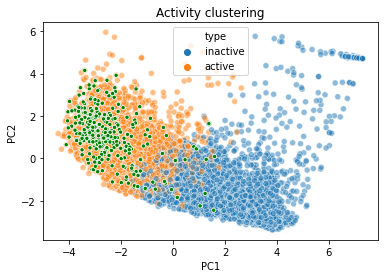

In [10]:
# Plot PC1 and PC2
%matplotlib inline
plt.figure()
sns.scatterplot(x="PC1", y="PC2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

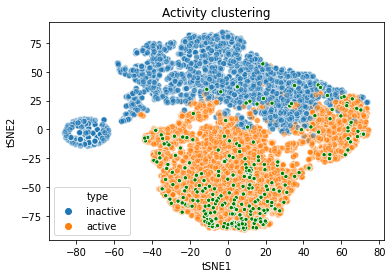

In [11]:
# Plot tSNE1 and tSNE2
%matplotlib inline
plt.figure()
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

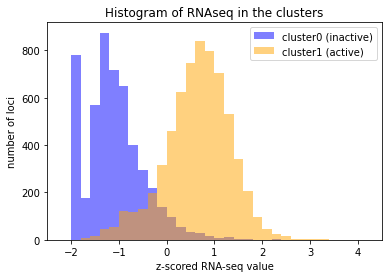

In [12]:
# Distribution of RNAseq in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=False, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=False, label='cluster1 (active)')
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], 
#            np.zeros(n_adhesome_inactive)-20, color='blue', alpha=0.5, s=1)
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], 
#            np.zeros(n_adhesome_active)-10, color='orange', alpha=0.5, s=1)
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Histogram of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.show()

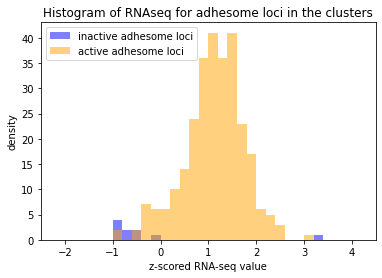

In [13]:
# Distribution of RNA-seq in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=False, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=False, label='active adhesome loci')
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('density')
plt.title('Histogram of RNAseq for adhesome loci in the clusters')
plt.legend(loc='upper left')
plt.show()

In [14]:
# Save all active/inactive loci to pickle
all_active_loci = df_clusters[df_clusters['type']=='active'].index.tolist()
pickle.dump(all_active_loci ,open(saving_dir+'all_active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
all_inactive_loci = df_clusters[df_clusters['type']=='inactive'].index.tolist()
pickle.dump(all_inactive_loci ,open(saving_dir+'all_inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Import adhesome loci

In [15]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = lu.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = lu.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df['chrom_int'] = adhesome_loc_df['chrom'].str.split('chr').str[1].astype(int)
adhesome_genes = np.unique(adhesome_loc_df['gene'])
print('Final number of adhesome genes = '+str(len(adhesome_genes)))
# Construct data frame annotating each adhesome locus with gene
adhesome_chr_loci = adhesome_loc_df[['chrom','chrom_int','loci','gene']]
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])
adhesome_loci = [adhesome_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(adhesome_chr_loci))]
# Add locus ID column
adhesome_chr_loci['locus_id'] = ['chr_'+str(adhesome_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(adhesome_chr_loci))]
pickle.dump(adhesome_chr_loci, open(saving_dir+'adhesome_chr_loci.pkl', 'wb'))
# Visualize head of adhesome_chr_loci
print('Number of adhesome loci = '+str(len(adhesome_loci)))
adhesome_chr_loci.head()

Adhesome genes absent from UCSC genes: ['MSN', 'PPP2CA', 'SMPX', 'ARHGEF6', 'GRLF1', 'JUB', 'DDEF1', 'SH3KBP1', 'FLNA', 'ITGAW']
Final number of adhesome genes = 222
Number of adhesome loci = 305


/home/louiscam/projects/gpcr/code/figures0/utils.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [16]:
# List of all adhesome genes
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'].values)
pickle.dump(all_adhesome_genes ,open(saving_dir+'all_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [18]:
# Dictionary with adhesome locus as key and adhesome gene as value
adhesome_chr_loci_bis = adhesome_chr_loci.groupby('locus_id')['gene'].apply(lambda x: '_'.join(x)).reset_index()
adhesome_locus_gene_dict = {adhesome_chr_loci_bis.iloc[i,0]:adhesome_chr_loci_bis.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_bis))}
# Dictionary with adhesome gene as key and adhesome locus as value
adhesome_chr_loci_ter = adhesome_chr_loci.groupby('gene')['locus_id'].apply(lambda x: '_x_'.join(x)).reset_index()
adhesome_gene_locus_dict = {adhesome_chr_loci_ter.iloc[i,0]:adhesome_chr_loci_ter.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_ter))}

### Identify active/inactive adhesome loci

In [19]:
# Load annotated loci across all genome
df_clusters = pickle.load(open(saving_dir+'active_inactive_loci.pkl', 'rb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [20]:
# All loci in genome
all_loci = set(df_clusters.index)
pickle.dump(all_loci ,open(saving_dir+'all_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Total number of loci in genome = '+str(len(all_loci)))
# Active loci correspond to cluster 1
active_loci = list(df_clusters[df_clusters['cluster']==1].index)
pickle.dump(active_loci ,open(saving_dir+'active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of active loci in genome: '+str(len(active_loci)))
# Inactive loci correspond to cluster 0
inactive_loci = list(df_clusters[df_clusters['cluster']==0].index)
pickle.dump(inactive_loci ,open(saving_dir+'inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of inactive loci in genome: '+str(len(inactive_loci)))

Total number of loci in genome = 11537
Number of active loci in genome: 6452
Number of inactive loci in genome: 5085


In [21]:
# Dictionary of active loci for each chromosome
active_loci_dict = dict()
for chrom in range(1,22+1):
    active_loci_dict[chrom] = ([int(s.split('_')[3]) for s in active_loci if 'chr_'+str(chrom)+'_' in s])
pickle.dump(active_loci_dict ,open(saving_dir+'active_loci_dict.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# Identify all/active/inactive adhesome genes in the genome
pickle.dump(adhesome_genes ,open(saving_dir+'adhesome_genes_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
active_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(active_loci)]['gene'].values)
pickle.dump(active_adhesome_genes ,open(saving_dir+'active_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
active_intrinsic_adhesome_genes = [gene for gene in intrinsic_adhesome_genes if gene in active_adhesome_genes]
pickle.dump(active_intrinsic_adhesome_genes ,open(saving_dir+'active_intrinsic_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
inactive_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(inactive_loci)]['gene'].values)
pickle.dump(inactive_adhesome_genes ,open(saving_dir+'inactive_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Active/inactive adhesome loci per chromosome

In [23]:
# Add activity column to adhesome_chr_loci
adhesome_chr_loci['active'] = [adhesome_chr_loci.iloc[i]['locus_id'] in active_loci 
                               for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.to_csv(saving_dir+'adhesome_loci_activity.csv', header=True)
pickle.dump(adhesome_chr_loci ,open(saving_dir+'adhesome_chr_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# All adhesome loci
adhesome_chr_loci_unique = adhesome_chr_loci.drop_duplicates(subset='locus_id')
adhesome_loci_list = adhesome_chr_loci_unique['locus_id'].tolist()
pickle.dump(adhesome_loci_list ,open(saving_dir+'adhesome_loci_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Active adhesome loci
active_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==True]['locus_id'].values
pickle.dump(active_adhesome_loci ,open(saving_dir+'active_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Inactive adhesome loci
inactive_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==False]['locus_id'].values
pickle.dump(inactive_adhesome_loci ,open(saving_dir+'inactive_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

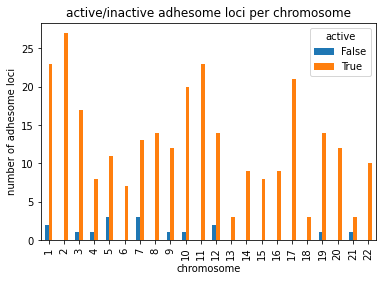

In [25]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci_unique.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

### Compare to random loci

In [26]:
# Create a dictionary of all non-adhesome, non adhesome-targeting TF active loci for each chromosome
all_active_loci_without_adhesome = list(set(active_loci)-set(active_adhesome_loci))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}
# Create a dictionary of all non-adhesome, non adhesome-targeting TF iactive loci for each chromosome
all_inactive_loci_without_adhesome = list(set(inactive_loci)-set(inactive_adhesome_loci))
inactive_loci_pool = {chrom: [locus for locus in all_inactive_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [27]:
# List of all active adhesome genes
number_active_adhesome_per_chrom = {chrom: len([locus for locus in active_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [28]:
# Create list out of all adhesome and random groups of loci
random_active_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb')))
random_inactive_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'rb')))
# Group all loci list by chromosome
active_adhesome_loci = active_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_adhesome_loci])]
inactive_adhesome_loci = inactive_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in inactive_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_loci])]
random_inactive_non_adhesome_loci = random_inactive_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_inactive_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))

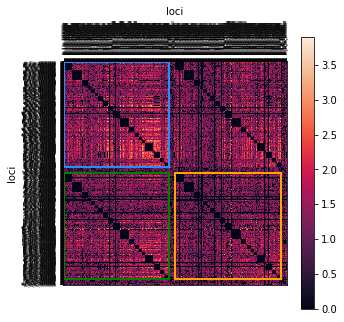

In [29]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(active_adhesome_loci), len(active_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci),len(active_adhesome_loci),'orange'],
                [0, len(active_adhesome_loci)+len(inactive_adhesome_loci),len(random_active_non_adhesome_loci),len(random_active_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

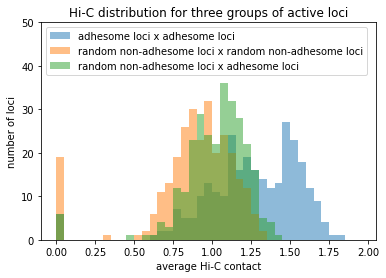

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=13.98403678358168, pvalue=1.951003771722823e-44)


In [30]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = contacts_df1.loc[active_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_hic_with_itself.values,
                  random_active_adhesome_hic_with_itself))

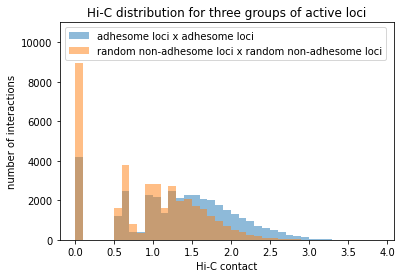

In [31]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[active_adhesome_loci,
                                                   active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_active_non_adhesome_loci,
                                                          random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = sorted(contacts_df1.loc[active_adhesome_loci,
                                                 random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
#plt.vlines(x=1.5, ymin=0, ymax=9000, color='red', linestyle='dashed')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,11000)
plt.legend(loc='upper left')
plt.show()

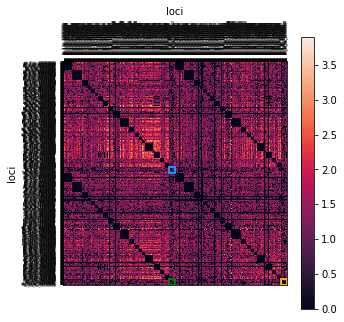

In [32]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[len(active_adhesome_loci), len(active_adhesome_loci),len(inactive_adhesome_loci),len(inactive_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'orange'],
                [len(active_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

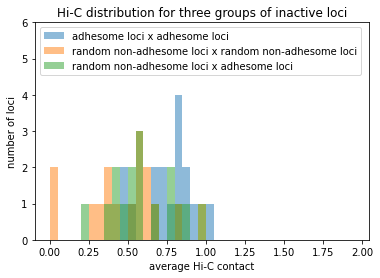

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=3.0528023638498567, pvalue=0.0022671520041358897)


In [33]:
# Histogram of average Hi-C contacts in three inactive cases
# Group of inactive adhesome loci with itself
inactive_adhesome_hic_with_itself = contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = contacts_df1.loc[random_inactive_non_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with inactive adhesome loci
random_versus_adhesome_inactive = contacts_df1.loc[inactive_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_inactive, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,6)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(inactive_adhesome_hic_with_itself.values,
                  random_inactive_adhesome_hic_with_itself))

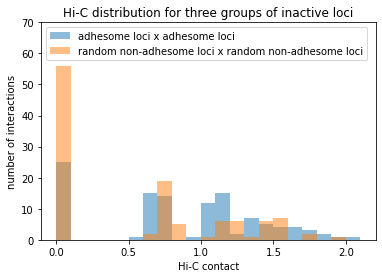

In [34]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci]))
num_zeros_intraX = sum([int(number_inactive_adhesome_per_chrom[chrom]*(number_inactive_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[inactive_adhesome_loci,
                                                   inactive_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_inactive_non_adhesome_loci,
                                                          random_inactive_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,70)
plt.legend(loc='upper left')
plt.show()

### Supplement: show HiC connections between chromosomes

In [35]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [36]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 60.88it/s]


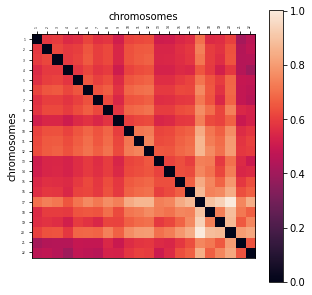

In [37]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())

# Network analysis

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [38]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

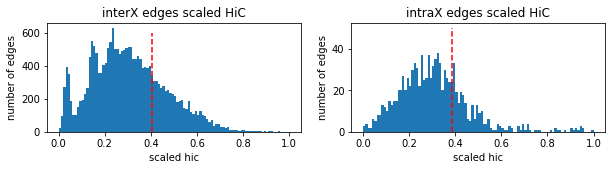

In [39]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75), ymin=0, ymax=600, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75), ymin=0, ymax=50, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

### Genomic features for each adhesome gene

In [40]:
# Load pairwise Spearman correlations between adhesome genes
adhesome_loc_corr = pickle.load(open(saving_dir+'adhesome_loc_corr.pkl','rb'))

In [41]:
# Add Spearman correlation to interX edge list
adhesome_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                    adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]

In [42]:
# Add Spearman correlation to intraX edge list
adhesome_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                    adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]

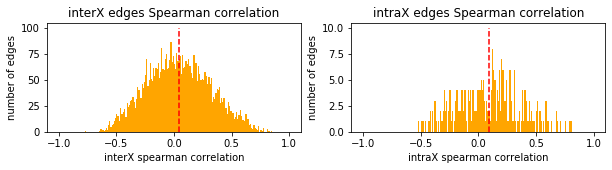

interX test:
Ttest_1sampResult(statistic=10.671542822333917, pvalue=2.6041640975511676e-26)
KstestResult(statistic=0.05971342601621166, pvalue=2.4261690239831647e-16)
intraX test:
Ttest_1sampResult(statistic=5.554949893790212, pvalue=6.85970365583147e-08)
KstestResult(statistic=0.16559937438745986, pvalue=1.0063304571875272e-06)


In [43]:
# Plot distribution of Spearman correlation in selected edges
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u]
[['source','target','hic','scaled_hic','spearman_corr']]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(inter_selected['spearman_corr']), ymin=0, ymax=100, color='red', linestyle='dashed')
plt.xlabel('interX spearman correlation')
plt.ylabel('number of edges')
plt.title('interX edges Spearman correlation')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(intra_selected['spearman_corr']), ymin=0, ymax=10, color='red', linestyle='dashed')
plt.xlabel('intraX spearman correlation')
plt.ylabel('number of edges')
plt.title('intraX edges Spearman correlation')

plt.show()
# Run statistical tests
print('interX test:')
print(ss.ttest_1samp(inter_selected['spearman_corr'], popmean=0))
print(ss.kstest(inter_selected['spearman_corr']/np.std(inter_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))
print('intraX test:')
print(ss.ttest_1samp(intra_selected['spearman_corr'], popmean=0))
print(ss.kstest(intra_selected['spearman_corr']/np.std(intra_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))

# Clustering analysis

In [43]:
# Parameters
hic_threshold = 0.75
with_intra = True
weights = 'spearman_corr'
hc_threshold = 0.62

In [44]:
# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(active_adhesome_genes)

### Clustering with VOTE+BOEM

Objective value after vote =  211.487
Objective value after boem =  205.839
Number of clusters =  148
Number of singletons = 102
Number of nodes in non trivial clusters = 117
Size of clusters


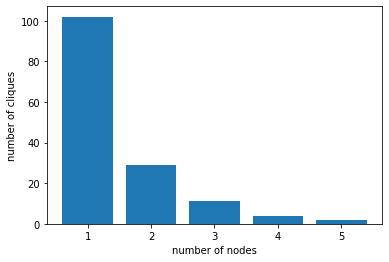

In [45]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_graph2_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_wcc, return_counts=True)[1],return_counts=True)
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_wcc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [46]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_wcc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_nointra.html")

### Clustering with hierarchical clustering

Number of clusters = 154
Number of singletons = 100
Number of nodes in non trivial clusters = 119
Size of clusters


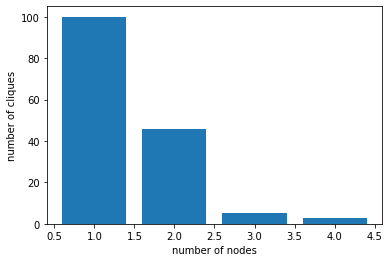

In [47]:
clustering_graph2_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [48]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clusteredG_hc_intra.html')

### Sanity checks

In [49]:
# Produce a random clustering for comparison with same number of clusters as WCC
np.random.seed(14)
clustering_graph2_random = np.random.permutation(clustering_graph2_wcc)

In [50]:
# Strongest edges (Spearman correlation)
adhesome_edge_list_sorted = adhesome_edge_list.sort_values(by='spearman_corr', ascending=False)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659
12643,NRP1,RNF185,1.896217,0.409967,0.827942
4223,CSK,GIT1,2.443617,0.571054,0.819366
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715
2058,ARPC2,RHOA,2.529139,0.596221,0.813830


In [51]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_wcc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,5] = (clustering_graph2_wcc[index_gene1]==clustering_graph2_wcc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True


In [52]:
# Check whether these edges are clustered together in HC
adhesome_edge_list_sorted['coclustered_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,6] = (clustering_graph2_hc[index_gene1]==clustering_graph2_hc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True


In [53]:
# Check whether these edges are clustered together in the random clustering
adhesome_edge_list_sorted['coclustered_random'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,7] = (clustering_graph2_random[index_gene1]==clustering_graph2_random[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True,True,False
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,False
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True,True,False
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,False


In [54]:
# Check whether these edges are clustered together in both WCC and HC
adhesome_edge_list_sorted['coclustered_wcc_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,8] = (adhesome_edge_list_sorted.iloc[i,5]==True) and (adhesome_edge_list_sorted.iloc[i,6]==True)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True,True,False,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,False,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True,True,False,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,False,True


In [55]:
# Check whether WCC and HCC produce similar clusters
adhesome_edge_list_sorted['hc_wcc_match'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    adhesome_edge_list_sorted.iloc[i,9] = (adhesome_edge_list_sorted.iloc[i,5]==adhesome_edge_list_sorted.iloc[i,6])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True,True,False,True,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False,False,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,False,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True,True,False,True,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,False,True,True


In [56]:
# Compute cumsums
adhesome_edge_list_sorted['coclustered_wcc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_random_cumsum'] = adhesome_edge_list_sorted['coclustered_random'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_wcc_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['hc_wcc_match_cumsum'] = adhesome_edge_list_sorted['hc_wcc_match'].astype(int).cumsum()
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match,coclustered_wcc_cumsum,coclustered_hc_cumsum,coclustered_random_cumsum,coclustered_wcc_hc_cumsum,hc_wcc_match_cumsum
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,True,True,False,True,True,1,1,0,1,1
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False,False,False,1,2,0,1,1
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,False,True,True,2,3,0,2,2
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,True,True,False,True,True,3,4,0,3,3
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,False,True,True,4,5,0,4,4


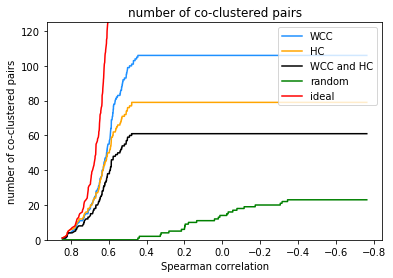

In [57]:
# Plot number of co-clustered pairs versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_cumsum'],
         color='dodgerblue', label='WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_hc_cumsum'],
         color='orange', label='HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_hc_cumsum'],
         color='black', label='WCC and HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_random_cumsum'],
         color='green', label='random')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend(loc='upper right')
plt.xlabel('Spearman correlation')
plt.ylabel('number of co-clustered pairs')
plt.ylim([0,125])
plt.title('number of co-clustered pairs')
plt.show()

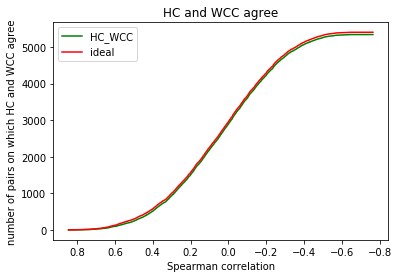

In [58]:
# Plot number of clustered pairs on which HC and WCC agree versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['hc_wcc_match_cumsum'],
         color='green', label='HC_WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of pairs on which HC and WCC agree')
plt.title('HC and WCC agree')
plt.show()

In [59]:
# Adjusted mutual information
adjusted_mutual_info_score(labels_true=clustering_graph2_wcc,
                           labels_pred=clustering_graph2_hc, 
                           average_method='min')

0.7500968171566754

### Robustness of WCC

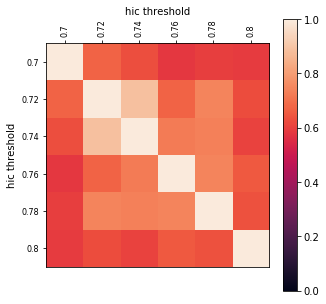

In [60]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_wcc.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_wcc.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 1, 8)

### Robustness of HC

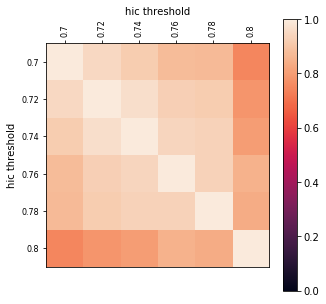

In [61]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_hc.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_hc.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 1, 8)

### AMI between HC and WCC

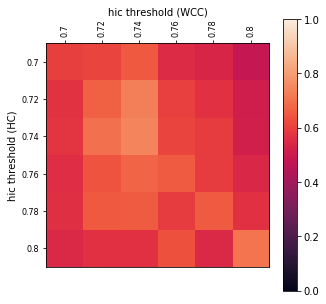

In [62]:
# Load HC and WCC clusterings
hc_dict = pickle.load(open(saving_dir+'dict_intra_hc.pickle','rb'))
wcc_dict = pickle.load(open(saving_dir+'dict_intra_wcc.pickle','rb'))
# hc_dict = pickle.load(open(saving_dir+'dict_nointra_hc.pickle','rb'))
# wcc_dict = pickle.load(open(saving_dir+'dict_nointra_wcc.pickle','rb'))
hic_threshold_list = hc_dict.keys()

# Fill in Adjusted Mutual Information between clusterings
ami_table = pd.DataFrame(1,index=hic_threshold_list, columns=hic_threshold_list)
for t,u in itertools.product(hic_threshold_list,hic_threshold_list):
    ami_table.loc[t,u] = adjusted_mutual_info_score(labels_true=hc_dict[t],labels_pred=wcc_dict[u],
                                                    average_method='min')
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold (WCC)', 'hic threshold (HC)', 5, 1, 8)

-----------------------------------------------------------------------------------------------------------------

# Network analysis - with adhesome TFs

### Prerequisite data

In [153]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
pickle.dump(df_loc, open(saving_dir+'df_loc.pkl', 'wb'))

In [88]:
# Load adhesome loci and loci of TF targeting adhesome genes
tf_targeting_active_adhesome = pickle.load(open(saving_dir+'tf_targeting_active_adhesome.pkl', 'rb'))
adh_tf_chr_loci = pickle.load(open(saving_dir+'adh_tf_chr_loci.pkl', 'rb'))
adh_tf_genes = np.unique(adh_tf_chr_loci[adh_tf_chr_loci['active']==True]['gene'])
pickle.dump(adh_tf_genes, open(saving_dir+'adh_tf_genes.pkl', 'wb'))
adh_tf_loci = np.unique(adh_tf_chr_loci[adh_tf_chr_loci['active']==True]['locus_id'])
adh_tf_locus_gene_dict = pickle.load(open(saving_dir+'adh_tf_locus_gene_dict.pkl', 'rb'))
adh_tf_gene_locus_dict = pickle.load(open(saving_dir+'adh_tf_gene_locus_dict.pkl', 'rb'))
contacts_df2_tf = pickle.load(open(saving_dir+'contacts_df2_tf.pkl', 'rb'))

In [150]:
# Save active adhesome TFs targeting active adhesome genes
active_tfs_targeting_active_adhesome = np.unique(
    adh_tf_chr_loci[(adh_tf_chr_loci['gene'].isin(tf_targeting_active_adhesome)) & 
                    (adh_tf_chr_loci['active']==True)]['gene'].values)
pickle.dump(active_tfs_targeting_active_adhesome, open(saving_dir+'active_tfs_targeting_active_adhesome.pkl', 'wb'))

### Network of adhesome genes + adhesome TFs: interX edges

### Network of adhesome genes + adhesome TFs: intraX edges

### Network of adhesome genes: interX and intraX

In [46]:
# Load edge lists
selected_interX_edge_list = pickle.load(open(saving_dir+'selected_interX_edge_list.pkl', 'rb'))
selected_intraX_edge_list = pickle.load(open(saving_dir+'selected_intraX_edge_list.pkl', 'rb'))

Number of interX edges selected = 12110
Number of intraX edges selected = 0


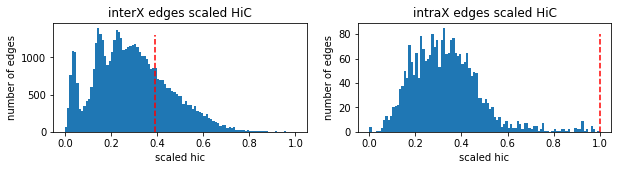

In [338]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(selected_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(selected_interX_edge_list['scaled_hic'],0.75), ymin=0, ymax=1300, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')
print('Number of interX edges selected = '+
      str(len(selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>np.quantile(selected_interX_edge_list['scaled_hic'],0.75)])))

plt.subplot(1, 2, 2)
plt.hist(selected_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(selected_intraX_edge_list['scaled_hic'],1), ymin=0, ymax=80, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')
print('Number of intraX edges selected = '+
      str(len(selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>np.quantile(selected_intraX_edge_list['scaled_hic'],1)])))

plt.show()

### Genomic features for each adhesome gene

In [339]:
# Load pairwise Spearman correlations between selected genes
adh_tf_loc_corr = pickle.load(open(saving_dir+'adh_tf_loc_corr.pkl','rb'))

In [340]:
# Add Spearman correlation to interX edge list
selected_interX_edge_list['spearman_corr'] = [adh_tf_loc_corr.loc[selected_interX_edge_list.iloc[i]['source'],
                                                                  selected_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(selected_interX_edge_list))]
selected_interX_edge_list.head()

,source,target,hic,scaled_hic,spearman_corr
0,ABI1,ABI2,0.913088,0.121775,0.488493
1,ABI1,ABL1,0.874730,0.110502,0.428246
2,ABI1,ACTB,1.079872,0.170793,-0.291142
3,ABI1,ACTN1,1.480107,0.288423,-0.012592
4,ABI1,AGAP2,0.672833,0.051164,-0.375814


In [341]:
# Add Spearman correlation to intraX edge list
selected_intraX_edge_list['spearman_corr'] = [adh_tf_loc_corr.loc[selected_intraX_edge_list.iloc[i]['source'],
                                                                  selected_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(selected_intraX_edge_list))]
selected_intraX_edge_list.head()

,source,target,hic,chrom,gen_dist,scaled_hic,spearman_corr
0,ABI1,ADAM12,2.312062,10,403.188976,0.185383,0.051238
1,ABI1,DOCK1,2.671161,10,407.318524,0.224570,0.406535
2,ABI1,LDB3,3.537248,10,245.477418,0.319080,-0.220256
3,ABI1,MAPK8,4.011600,10,90.134594,0.370843,0.359640
4,ABI1,NRP1,4.410741,10,25.809422,0.414399,0.173035


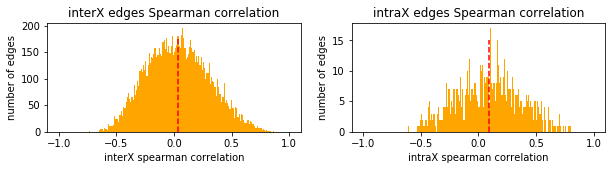

interX test:
Ttest_1sampResult(statistic=15.273342926646757, pvalue=3.523887768619416e-52)
KstestResult(statistic=0.051431499019262916, pvalue=3.000586565680078e-28)
intraX test:
Ttest_1sampResult(statistic=8.218154092042909, pvalue=1.1845407703058157e-15)
KstestResult(statistic=0.14533804364418262, pvalue=4.6509419797556196e-12)


In [342]:
# Plot distribution of Spearman correlation in selected edges
t = np.quantile(selected_interX_edge_list['scaled_hic'],0.75)
u = np.quantile(selected_intraX_edge_list['scaled_hic'],0.75)
inter_selected = selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>t]
intra_selected = selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>u]
[['source','target','hic','scaled_hic','spearman_corr']]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(inter_selected['spearman_corr']), ymin=0, ymax=180, color='red', linestyle='dashed')
plt.xlabel('interX spearman correlation')
plt.ylabel('number of edges')
plt.title('interX edges Spearman correlation')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(intra_selected['spearman_corr']), ymin=0, ymax=15, color='red', linestyle='dashed')
plt.xlabel('intraX spearman correlation')
plt.ylabel('number of edges')
plt.title('intraX edges Spearman correlation')

plt.show()
# Run statistical tests
print('interX test:')
print(ss.ttest_1samp(inter_selected['spearman_corr'], popmean=0))
print(ss.kstest(inter_selected['spearman_corr']/np.std(inter_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))
print('intraX test:')
print(ss.ttest_1samp(intra_selected['spearman_corr'], popmean=0))
print(ss.kstest(intra_selected['spearman_corr']/np.std(intra_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))

# Clustering analysis

In [356]:
# Parameters
hic_threshold = 0.75
with_intra = True
weights = 'spearman_corr'
hc_threshold = 0.62

In [357]:
# Selected edge list
t = np.quantile(selected_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(selected_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>t]
intra_selected = selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
selected_edge_list = inter_selected
if with_intra == True:
    selected_edge_list = pd.concat([selected_edge_list,intra_selected])
G = nx.from_pandas_edgelist(selected_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(adh_tf_genes)
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))

Total number of nodes in G = 339
Total number of edges in G = 12739
Average node degree in G = 75.15634218289085
Number of connected components in G = 12
Size of connected components = [328, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Clustering with VOTE+BOEM

Objective value after vote =  472.455
Objective value after boem =  461.302
Number of clusters =  220
Number of singletons = 145
Number of nodes in non trivial clusters = 194
Size of clusters


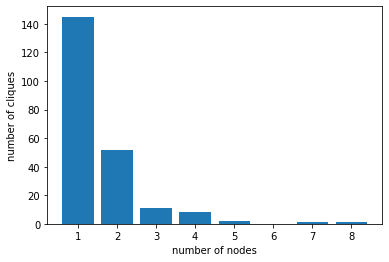

In [358]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(selected_interX_edge_list, 
                                               selected_intraX_edge_list,
                                               adh_tf_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_graph2_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_wcc, return_counts=True)[1],return_counts=True)
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_wcc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [359]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_wcc])]
cG.remove_nodes_from(singletons)
# Save network to html
oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_nointra_withtfs.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clusteredG_wcc_intra_withtfs.html')

### Clustering with hierarchical clustering

Number of clusters = 227
Number of singletons = 139
Number of nodes in non trivial clusters = 200
Size of clusters


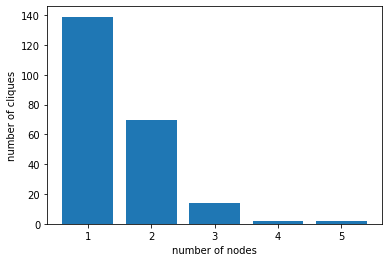

In [360]:
clustering_graph2_hc = cc.hierarchical_clustering(selected_interX_edge_list, 
                                                  selected_intraX_edge_list,
                                                  adh_tf_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [361]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in active_adhesome_genes) for i in range(n)}, "adhesome_gene")
nx.set_node_attributes(cG, {labels[i]: str(labels[i] in tf_targeting_active_adhesome) for i in range(n)}, "adhesome_tf_gene")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra_withtfs.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra_withtfs.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clusteredG_hc_intra_withtfs.html')

### Sanity checks

In [219]:
# Produce a random clustering for comparison with same number of clusters as WCC
np.random.seed(14)
clustering_graph2_random = np.random.permutation(clustering_graph2_wcc)

In [220]:
# Strongest edges (Spearman correlation)
selected_edge_list_sorted = selected_edge_list.sort_values(by='spearman_corr', ascending=False)
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399
28281,NRP1,RNF185,1.896217,0.410719,0.838037
15226,HIPK2,PTK2,2.028446,0.449581,0.831850
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531


In [221]:
# Check whether these edges are clustered together in WCC
selected_edge_list_sorted['coclustered_wcc'] = 0
for i in range(len(selected_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,1])[0])
    selected_edge_list_sorted.iloc[i,5] = (clustering_graph2_wcc[index_gene1]==clustering_graph2_wcc[index_gene2])
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True


In [222]:
# Check whether these edges are clustered together in HC
selected_edge_list_sorted['coclustered_hc'] = 0
for i in range(len(selected_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,1])[0])
    selected_edge_list_sorted.iloc[i,6] = (clustering_graph2_hc[index_gene1]==clustering_graph2_hc[index_gene2])
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True,True
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False,True
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True,True
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True,True
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True,True


In [223]:
# Check whether these edges are clustered together in the random clustering
selected_edge_list_sorted['coclustered_random'] = 0
for i in range(len(selected_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,1])[0])
    selected_edge_list_sorted.iloc[i,7] = (clustering_graph2_random[index_gene1]==clustering_graph2_random[index_gene2])
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True,True,False
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False,True,False
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True,True,False
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True,True,False
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True,True,False


In [224]:
# Check whether these edges are clustered together in both WCC and HC
selected_edge_list_sorted['coclustered_wcc_hc'] = 0
for i in range(len(selected_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==selected_edge_list_sorted.iloc[i,1])[0])
    selected_edge_list_sorted.iloc[i,8] = (selected_edge_list_sorted.iloc[i,5]==True) and (selected_edge_list_sorted.iloc[i,6]==True)
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True,True,False,True
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False,True,False,False
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True,True,False,True
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True,True,False,True
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True,True,False,True


In [225]:
# Check whether WCC and HCC produce similar clusters
selected_edge_list_sorted['hc_wcc_match'] = 0
for i in range(len(selected_edge_list_sorted)):
    selected_edge_list_sorted.iloc[i,9] = (selected_edge_list_sorted.iloc[i,5]==selected_edge_list_sorted.iloc[i,6])
selected_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True,True,False,True,True
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False,True,False,False,False
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True,True,False,True,True
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True,True,False,True,True
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True,True,False,True,True


In [226]:
# Compute cumsums
selected_edge_list_sorted['coclustered_wcc_cumsum'] = selected_edge_list_sorted['coclustered_wcc'].astype(int).cumsum()
selected_edge_list_sorted['coclustered_hc_cumsum'] = selected_edge_list_sorted['coclustered_hc'].astype(int).cumsum()
selected_edge_list_sorted['coclustered_random_cumsum'] = selected_edge_list_sorted['coclustered_random'].astype(int).cumsum()
selected_edge_list_sorted['coclustered_wcc_hc_cumsum'] = selected_edge_list_sorted['coclustered_wcc_hc'].astype(int).cumsum()
selected_edge_list_sorted['hc_wcc_match_cumsum'] = selected_edge_list_sorted['hc_wcc_match'].astype(int).cumsum()
selected_edge_list_sorted.head(10)

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match,coclustered_wcc_cumsum,coclustered_hc_cumsum,coclustered_random_cumsum,coclustered_wcc_hc_cumsum,hc_wcc_match_cumsum
34522,PTPRO,PDE4D,2.330510,0.538358,0.860399,True,True,False,True,True,1,1,0,1,1
28281,NRP1,RNF185,1.896217,0.410719,0.838037,False,True,False,False,False,1,2,0,1,1
15226,HIPK2,PTK2,2.028446,0.449581,0.831850,True,True,False,True,True,2,3,0,2,2
30044,PEAK1,ZNF148,1.902567,0.412585,0.826748,True,True,False,True,True,3,4,0,3,3
25158,MAPK8IP3,RXRA,2.446641,0.572489,0.826531,True,True,False,True,True,4,5,0,4,4
8184,CSK,GIT1,2.443617,0.571600,0.817846,True,True,False,True,True,5,6,0,5,5
3302,ARPC2,RHOA,2.529139,0.596735,0.811442,True,True,False,True,True,6,7,0,6,6
13671,GIT2,PRKCA,1.907407,0.414007,0.805471,True,True,False,True,True,7,8,0,7,7
20738,ITGB3,ITGB5,1.986165,0.437155,0.803843,True,True,False,True,True,8,9,0,8,8
5951,CBL,PTK2,1.990875,0.438539,0.803734,False,False,False,False,True,8,9,0,8,9


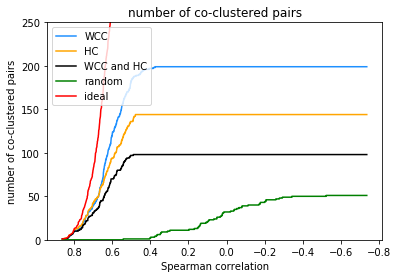

In [227]:
# Plot number of co-clustered pairs versus Spearman correlation
plt.figure()
plt.plot(selected_edge_list_sorted['spearman_corr'],
         selected_edge_list_sorted['coclustered_wcc_cumsum'],
         color='dodgerblue', label='WCC')
plt.plot(selected_edge_list_sorted['spearman_corr'],
         selected_edge_list_sorted['coclustered_hc_cumsum'],
         color='orange', label='HC')
plt.plot(selected_edge_list_sorted['spearman_corr'],
         selected_edge_list_sorted['coclustered_wcc_hc_cumsum'],
         color='black', label='WCC and HC')
plt.plot(selected_edge_list_sorted['spearman_corr'],
         selected_edge_list_sorted['coclustered_random_cumsum'],
         color='green', label='random')
plt.plot(selected_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(selected_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of co-clustered pairs')
plt.ylim([0,250])
plt.title('number of co-clustered pairs')
plt.show()

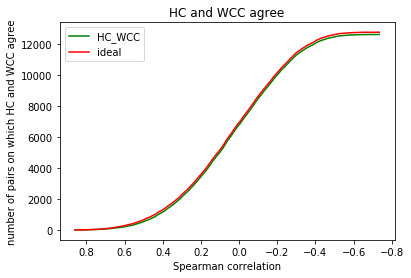

In [228]:
# Plot number of clustered pairs on which HC and WCC agree versus Spearman correlation
plt.figure()
plt.plot(selected_edge_list_sorted['spearman_corr'],
         selected_edge_list_sorted['hc_wcc_match_cumsum'],
         color='green', label='HC_WCC')
plt.plot(selected_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(selected_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of pairs on which HC and WCC agree')
plt.title('HC and WCC agree')
plt.show()

In [229]:
# Adjusted mutual information
adjusted_mutual_info_score(labels_true=clustering_graph2_wcc,
                           labels_pred=clustering_graph2_hc, 
                           average_method='min')

0.6761113879111348

### Robustness of WCC

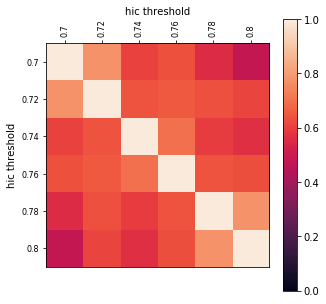

In [282]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_wcc_withtfs.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_wcc_withtfs.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 1, 8)

### Robustness of HC

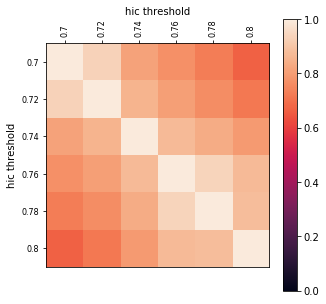

In [283]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_hc_withtfs.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_hc_withtfs.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 1, 8)

### AMI between HC and WCC

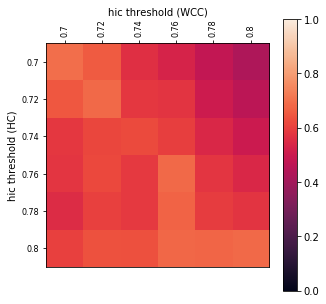

In [284]:
# Load HC and WCC clusterings
hc_dict = pickle.load(open(saving_dir+'dict_intra_hc_withtfs.pickle','rb'))
wcc_dict = pickle.load(open(saving_dir+'dict_intra_wcc_withtfs.pickle','rb'))
hic_threshold_list = hc_dict.keys()

# Fill in Adjusted Mutual Information between clusterings
ami_table = pd.DataFrame(1,index=hic_threshold_list, columns=hic_threshold_list)
for t,u in itertools.product(hic_threshold_list,hic_threshold_list):
    ami_table.loc[t,u] = adjusted_mutual_info_score(labels_true=hc_dict[t],labels_pred=wcc_dict[u],
                                                    average_method='min')
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold (WCC)', 'hic threshold (HC)', 5, 1, 8)

# Compare interX and interX/intraX clustering of adhesome genes

### Build interX network

In [44]:
# Parameters
hic_threshold = 0.72
with_intra = False
weights = 'spearman_corr'
hc_threshold = 0.62

# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_inter = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_inter.add_nodes_from(active_adhesome_genes)

In [45]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_inter_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_inter_wcc = G_inter.copy()
labels = np.array(sorted(G_inter_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: str(clustering_inter_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_wcc])]
G_inter_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_wcc, filename=saving_dir+"G_inter_wcc.html")

Objective value after vote =  195.41
Objective value after boem =  192.905
Number of clusters =  152


In [46]:
# Run HCC
clustering_inter_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_inter_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_inter_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_inter_hc)-comps[1][0]))

# Clustered graph
G_inter_hc = G_inter.copy()
labels = np.array(sorted(G_inter_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: str(clustering_inter_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_hc])]
G_inter_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_hc, filename=saving_dir+"G_inter_hc.html")

Number of clusters = 157
Number of singletons = 107
Number of nodes in non trivial clusters = 112


### Build intraX network

In [47]:
# Parameters
hic_threshold = 0.72
with_intra = True
weights = 'spearman_corr'
hc_threshold = 0.62

# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_intra = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_intra.add_nodes_from(active_adhesome_genes)

In [48]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_intra_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_intra_wcc = G_intra.copy()
labels = np.array(sorted(G_intra_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: str(clustering_intra_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_wcc])]
G_intra_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_wcc, filename=saving_dir+"G_intra_wcc.html")

Objective value after vote =  216.918
Objective value after boem =  209.982
Number of clusters =  146


In [49]:
# Run HCC
clustering_intra_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_intra_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_intra_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_intra_hc)-comps[1][0]))

# Clustered graph
G_intra_hc = G_intra.copy()
labels = np.array(sorted(G_intra_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: str(clustering_intra_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_hc])]
G_intra_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_hc, filename=saving_dir+"G_intra_hc.html")

Number of clusters = 152
Number of singletons = 97
Number of nodes in non trivial clusters = 122


### Cluster overlap matrix: WCC inter vs. WCC inter+intra

In [50]:
# For WCC 
overlap_wcc = pd.DataFrame(0,index=np.unique(clustering_inter_wcc), columns=np.unique(clustering_intra_wcc))
for i in overlap_wcc.index:
    for j in overlap_wcc.columns:
        wcc_inter = set(active_adhesome_genes[np.where(clustering_inter_wcc==i)[0]])
        wcc_intra = set(active_adhesome_genes[np.where(clustering_intra_wcc==j)[0]])
        if (len(wcc_inter)==1 or len(wcc_intra)==1):
            overlap_wcc.loc[i,j] = 0
        else:
            overlap_wcc.loc[i,j] = len(wcc_inter.intersection(wcc_intra))/len(wcc_inter.union(wcc_intra))

In [51]:
# Matching clusters
inter_cluster_ids = np.where(overlap_wcc>0.4)[0]+1
inter_clusters = [active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]] for c in inter_cluster_ids]
n_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]]) for c in inter_cluster_ids]
intra_cluster_ids = np.where(overlap_wcc>0.4)[1]+1
intra_clusters = [active_adhesome_genes[np.where(clustering_intra_wcc==c)[0]] for c in intra_cluster_ids]
n_intra_clusters = [len(active_adhesome_genes[np.where(clustering_intra_wcc==c)[0]]) for c in intra_cluster_ids]
match_prop = [overlap_wcc.loc[np.where(overlap_wcc>0.4)[0][i]+1,np.where(overlap_wcc>0.4)[1][i]+1] 
              for i in range(len(np.where(overlap_wcc>0.4)[0]))]
matching_clusters_wcc = pd.DataFrame({'inter_cluster_id': inter_cluster_ids,
                                      'intra_cluster_id': intra_cluster_ids,
                                      'inter_cluster': inter_clusters,                                   
                                      'intra_cluster': intra_clusters,
                                      'n_inter_clusters': n_inter_clusters,
                                      'n_intra_clusters': n_intra_clusters,
                                      'match': match_prop})
matching_clusters_wcc = matching_clusters_wcc.sort_values(by=['match','n_inter_clusters','n_intra_clusters'], 
                                                          ascending=False)

In [52]:
matching_clusters_wcc

,inter_cluster_id,intra_cluster_id,inter_cluster,intra_cluster,n_inter_clusters,n_intra_clusters,match
11,36,37,"[CRK, GIT2, NF2, PEAK1, PTPN2]","[CRK, GIT2, NF2, PEAK1, PTPN2]",5,5,1.000000
27,100,100,"[NRP1, RAPGEF1, RNF185, SLC9A1]","[NRP1, RAPGEF1, RNF185, SLC9A1]",4,4,1.000000
23,66,66,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5]",3,3,1.000000
24,67,67,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
1,8,8,"[AGAP2, ITGB4]","[AGAP2, ITGB4]",2,2,1.000000
3,17,17,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.000000
4,20,20,"[ASAP2, MACF1]","[ASAP2, MACF1]",2,2,1.000000
5,22,22,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000
6,23,23,"[BCAR3, PTEN]","[BCAR3, PTEN]",2,2,1.000000
8,25,25,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000


### Cluster overlap matrix: HC inter vs. HC inter+intra

In [53]:
# For HC 
overlap_hc = pd.DataFrame(0,index=np.unique(clustering_inter_hc), columns=np.unique(clustering_intra_hc))
for i in overlap_hc.index:
    for j in overlap_hc.columns:
        hc_inter = set(active_adhesome_genes[np.where(clustering_inter_hc==i)[0]])
        hc_intra = set(active_adhesome_genes[np.where(clustering_intra_hc==j)[0]])
        if (len(hc_inter)==1 or len(hc_intra)==1):
            overlap_hc.loc[i,j] = 0
        else:
            overlap_hc.loc[i,j] = len(hc_inter.intersection(hc_intra))/len(hc_inter.union(hc_intra))

In [54]:
# Matching clusters
inter_cluster_ids = np.where(overlap_hc>0.4)[0]+1
inter_clusters = [active_adhesome_genes[np.where(clustering_inter_hc==c)[0]] for c in inter_cluster_ids]
n_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_hc==c)[0]]) for c in inter_cluster_ids]
intra_cluster_ids = np.where(overlap_hc>0.4)[1]+1
intra_clusters = [active_adhesome_genes[np.where(clustering_intra_hc==c)[0]] for c in intra_cluster_ids]
n_intra_clusters = [len(active_adhesome_genes[np.where(clustering_intra_hc==c)[0]]) for c in intra_cluster_ids]
match_prop = [overlap_hc.loc[np.where(overlap_hc>0.4)[0][i]+1,np.where(overlap_hc>0.4)[1][i]+1] 
              for i in range(len(np.where(overlap_hc>0.4)[0]))]
matching_clusters_hc = pd.DataFrame({'inter_cluster_id': inter_cluster_ids,
                                     'intra_cluster_id': intra_cluster_ids,
                                     'inter_cluster': inter_clusters,                                   
                                     'intra_cluster': intra_clusters,
                                     'n_inter_clusters': n_inter_clusters,
                                     'n_intra_clusters': n_intra_clusters,
                                     'match': match_prop})
matching_clusters_hc = matching_clusters_hc.sort_values(by=['match','n_inter_clusters','n_intra_clusters'], 
                                                        ascending=False)

In [55]:
matching_clusters_hc

,inter_cluster_id,intra_cluster_id,inter_cluster,intra_cluster,n_inter_clusters,n_intra_clusters,match
1,2,16,"[HSPB1, NUDT16L1, SHARPIN]","[HSPB1, NUDT16L1, SHARPIN]",3,3,1.000000
5,25,45,"[PTPN11, PTPRA, TRPM7]","[PTPN11, PTPRA, TRPM7]",3,3,1.000000
18,93,14,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.000000
29,113,139,"[CBL, CRK, PTK2]","[CBL, CRK, PTK2]",3,3,1.000000
30,114,138,"[GIT2, NF2, PRKCA]","[GIT2, NF2, PRKCA]",3,3,1.000000
31,115,81,"[BCAR3, FERMT2, PTEN]","[BCAR3, FERMT2, PTEN]",3,3,1.000000
46,157,104,"[PEAK1, PTPN2, TRIO]","[PEAK1, PTPN2, TRIO]",3,3,1.000000
0,1,13,"[HSPA2, TUBA1B]","[HSPA2, TUBA1B]",2,2,1.000000
3,4,55,"[AGAP2, ITGB4]","[AGAP2, ITGB4]",2,2,1.000000
4,11,36,"[CAPN1, PTPRF]","[CAPN1, PTPRF]",2,2,1.000000


### Cluster overlap matrix: WCC inter vs. HC inter

In [53]:
# For HC 
overlap_whc_inter = pd.DataFrame(0,index=np.unique(clustering_inter_wcc), columns=np.unique(clustering_inter_hc))
for i in overlap_whc_inter.index:
    for j in overlap_whc_inter.columns:
        wcc_inter = set(active_adhesome_genes[np.where(clustering_inter_wcc==i)[0]])
        hc_inter = set(active_adhesome_genes[np.where(clustering_inter_hc==j)[0]])
        if (len(wcc_inter)==1 or len(hc_inter)==1):
            overlap_whc_inter.loc[i,j] = 0
        else:
            overlap_whc_inter.loc[i,j] = len(wcc_inter.intersection(hc_inter))/len(wcc_inter.union(hc_inter))

In [54]:
# Matching clusters
wcc_inter_cluster_ids = np.where(overlap_whc_inter>0.4)[0]+1
wcc_inter_clusters = [active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]] for c in wcc_inter_cluster_ids]
n_wcc_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]]) for c in wcc_inter_cluster_ids]
hc_inter_cluster_ids = np.where(overlap_whc_inter>0.4)[1]+1
hc_inter_clusters = [active_adhesome_genes[np.where(clustering_inter_hc==c)[0]] for c in hc_inter_cluster_ids]
n_hc_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_hc==c)[0]]) for c in hc_inter_cluster_ids]
match_prop = [overlap_whc_inter.loc[np.where(overlap_whc_inter>0.4)[0][i]+1,np.where(overlap_whc_inter>0.4)[1][i]+1] 
              for i in range(len(np.where(overlap_whc_inter>0.4)[0]))]
matching_clusters_whc_inter = pd.DataFrame({ 'wcc_inter_cluster_id': wcc_inter_cluster_ids,
                                             'hc_inter_cluster_id': hc_inter_cluster_ids,
                                             'wcc_inter_cluster': wcc_inter_clusters,                                   
                                             'hc_inter_cluster': hc_inter_clusters,
                                             'n_wcc_inter_clusters': n_wcc_inter_clusters,
                                             'n_hc_inter_clusters': n_hc_inter_clusters,
                                             'match': match_prop})
matching_clusters_whc_inter = matching_clusters_whc_inter.sort_values(by=['match','n_wcc_inter_clusters','n_hc_inter_clusters'], 
                                                        ascending=False)

# Compare interX and interX/intraX clustering of adhesome genes + TFs

### Build interX network

In [69]:
# Parameters
hic_threshold = 0.72
with_intra = False
weights = 'spearman_corr'
hc_threshold = 0.62

# Selected edge list
t = np.quantile(selected_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(selected_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = selected_interX_edge_list[selected_interX_edge_list['scaled_hic']>t]
intra_selected = selected_intraX_edge_list[selected_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_inter = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_inter.add_nodes_from(active_adhesome_genes)

In [70]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_inter_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_inter_wcc = G_inter.copy()
labels = np.array(sorted(G_inter_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: str(clustering_inter_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_wcc])]
G_inter_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_wcc, filename=saving_dir+"G_inter_wcc.html")

Objective value after vote =  198.372
Objective value after boem =  193.308
Number of clusters =  151


In [71]:
# Run HCC
clustering_inter_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_inter_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_inter_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_inter_hc)-comps[1][0]))

# Clustered graph
G_inter_hc = G_inter.copy()
labels = np.array(sorted(G_inter_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: str(clustering_inter_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_inter_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_inter_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_inter_hc])]
G_inter_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_inter_hc, filename=saving_dir+"G_inter_hc.html")

Number of clusters = 157
Number of singletons = 107
Number of nodes in non trivial clusters = 112


### Build intraX network

In [72]:
# Parameters
hic_threshold = 0.72
with_intra = True
weights = 'spearman_corr'
hc_threshold = 0.62

# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G_intra = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G_intra.add_nodes_from(active_adhesome_genes)

In [73]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               active_adhesome_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100)
clustering_intra_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)

# Clustered graph
G_intra_wcc = G_intra.copy()
labels = np.array(sorted(G_intra_wcc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: str(clustering_intra_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_wcc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_wcc])]
G_intra_wcc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_wcc, filename=saving_dir+"G_intra_wcc.html")

Objective value after vote =  216.021
Objective value after boem =  209.689
Number of clusters =  145


In [74]:
# Run HCC
clustering_intra_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  active_adhesome_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold)
# Clustering characteristics
comps = np.unique(np.unique(clustering_intra_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_intra_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_intra_hc)-comps[1][0]))

# Clustered graph
G_intra_hc = G_intra.copy()
labels = np.array(sorted(G_intra_hc.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: str(clustering_intra_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(G_intra_hc, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_intra_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_intra_hc])]
G_intra_hc.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(G_intra_hc, filename=saving_dir+"G_intra_hc.html")

Number of clusters = 152
Number of singletons = 97
Number of nodes in non trivial clusters = 122


### Cluster overlap matrix

In [108]:
# For WCC 
overlap_wcc = pd.DataFrame(0,index=np.unique(clustering_inter_wcc), columns=np.unique(clustering_intra_wcc))
for i in overlap_wcc.index:
    for j in overlap_wcc.columns:
        wcc_inter = set(active_adhesome_genes[np.where(clustering_inter_wcc==i)[0]])
        wcc_intra = set(active_adhesome_genes[np.where(clustering_intra_wcc==j)[0]])
        if (len(wcc_inter)==1 or len(wcc_intra)==1):
            overlap_wcc.loc[i,j] = 0
        else:
            overlap_wcc.loc[i,j] = len(wcc_inter.intersection(wcc_intra))/len(wcc_inter.union(wcc_intra))

In [145]:
# Matching clusters
inter_cluster_ids = np.where(overlap_wcc>0.4)[0]+1
inter_clusters = [active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]] for c in inter_cluster_ids]
n_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_wcc==c)[0]]) for c in inter_cluster_ids]
intra_cluster_ids = np.where(overlap_wcc>0.4)[1]+1
intra_clusters = [active_adhesome_genes[np.where(clustering_intra_wcc==c)[0]] for c in intra_cluster_ids]
n_intra_clusters = [len(active_adhesome_genes[np.where(clustering_intra_wcc==c)[0]]) for c in intra_cluster_ids]
match_prop = [overlap_wcc.loc[np.where(overlap_wcc>0.4)[0][i]+1,np.where(overlap_wcc>0.4)[1][i]+1] 
              for i in range(len(np.where(overlap_wcc>0.4)[0]))]
matching_clusters_wcc = pd.DataFrame({'inter_cluster_id': inter_cluster_ids,
                                      'intra_cluster_id': intra_cluster_ids,
                                      'inter_cluster': inter_clusters,                                   
                                      'intra_cluster': intra_clusters,
                                      'n_inter_clusters': n_inter_clusters,
                                      'n_intra_clusters': n_intra_clusters,
                                      'match': match_prop})
matching_clusters_wcc = matching_clusters_wcc.sort_values(by=['match','n_inter_clusters','n_intra_clusters'], 
                                                          ascending=False)

In [147]:
matching_clusters_wcc

,inter_cluster_id,intra_cluster_id,inter_cluster,intra_cluster,n_inter_clusters,n_intra_clusters,match
0,4,4,"[ABL1, CBL, GIT2, NF2, PRKCA]","[ABL1, CBL, GIT2, NF2, PRKCA]",5,5,1.000000
9,34,33,"[CIB2, ITGAL, ITGB2, SRCIN1]","[CIB2, ITGAL, ITGB2, SRCIN1]",4,4,1.000000
14,51,50,"[FERMT2, MAPK1, PPFIA1, PTK2]","[FERMT2, MAPK1, PPFIA1, PTK2]",4,4,1.000000
22,66,64,"[ITGA11, ITGB3, ITGB5]","[ITGA11, ITGB3, ITGB5]",3,3,1.000000
23,67,65,"[ITGA2, PARVA, PTPN1]","[ITGA2, PARVA, PTPN1]",3,3,1.000000
30,110,107,"[PEAK1, PTPN2, TRIO]","[PEAK1, PTPN2, TRIO]",3,3,1.000000
1,8,8,"[AGAP2, ITGB4]","[AGAP2, ITGB4]",2,2,1.000000
2,17,17,"[ARHGEF2, LRP1]","[ARHGEF2, LRP1]",2,2,1.000000
3,20,20,"[ASAP2, MACF1]","[ASAP2, MACF1]",2,2,1.000000
4,22,22,"[BCAR1, MYH9]","[BCAR1, MYH9]",2,2,1.000000


In [132]:
# For HC 
overlap_hc = pd.DataFrame(0,index=np.unique(clustering_inter_hc), columns=np.unique(clustering_intra_hc))
for i in overlap_hc.index:
    for j in overlap_hc.columns:
        hc_inter = set(active_adhesome_genes[np.where(clustering_inter_hc==i)[0]])
        hc_intra = set(active_adhesome_genes[np.where(clustering_intra_hc==j)[0]])
        if (len(hc_inter)==1 or len(hc_intra)==1):
            overlap_hc.loc[i,j] = 0
        else:
            overlap_hc.loc[i,j] = len(hc_inter.intersection(hc_intra))/len(hc_inter.union(hc_intra))

In [142]:
# Matching clusters
inter_cluster_ids = np.where(overlap_hc>0.4)[0]+1
inter_clusters = [active_adhesome_genes[np.where(clustering_inter_hc==c)[0]] for c in inter_cluster_ids]
n_inter_clusters = [len(active_adhesome_genes[np.where(clustering_inter_hc==c)[0]]) for c in inter_cluster_ids]
intra_cluster_ids = np.where(overlap_hc>0.4)[1]+1
intra_clusters = [active_adhesome_genes[np.where(clustering_intra_hc==c)[0]] for c in intra_cluster_ids]
n_intra_clusters = [len(active_adhesome_genes[np.where(clustering_intra_hc==c)[0]]) for c in intra_cluster_ids]
match_prop = [overlap_hc.loc[np.where(overlap_hc>0.4)[0][i]+1,np.where(overlap_hc>0.4)[1][i]+1] 
              for i in range(len(np.where(overlap_hc>0.4)[0]))]
matching_clusters_hc = pd.DataFrame({'inter_cluster_id': inter_cluster_ids,
                                     'intra_cluster_id': intra_cluster_ids,
                                     'inter_cluster': inter_clusters,                                   
                                     'intra_cluster': intra_clusters,
                                     'n_inter_clusters': n_inter_clusters,
                                     'n_intra_clusters': n_intra_clusters,
                                     'match': match_prop})
matching_clusters_hc = matching_clusters_hc.sort_values(by=['match','n_inter_clusters','n_intra_clusters'], 
                                                        ascending=False)

In [144]:
matching_clusters_hc.head()

,inter_cluster_id,intra_cluster_id,inter_cluster,intra_cluster,n_inter_clusters,n_intra_clusters,match
1,2,16,"[HSPB1, NUDT16L1, SHARPIN]","[HSPB1, NUDT16L1, SHARPIN]",3,3,1.0
5,25,45,"[PTPN11, PTPRA, TRPM7]","[PTPN11, PTPRA, TRPM7]",3,3,1.0
18,93,14,"[AKT1, HRAS, SH2B1]","[AKT1, HRAS, SH2B1]",3,3,1.0
29,113,139,"[CBL, CRK, PTK2]","[CBL, CRK, PTK2]",3,3,1.0
30,114,138,"[GIT2, NF2, PRKCA]","[GIT2, NF2, PRKCA]",3,3,1.0
